In [75]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from math import sqrt

In [76]:
class SLR():
    '''
    
    Class for implamintation of Simple Linear Regression (SLR)

    '''
    def __init__(self):
        '''
        
        Class constructor

        Attributes:
            PATH_TO_DATASET [str]: relative path to data with positive relation
            PATH_DO_NEGATIVE_DATASET [str]: relative path to data with positive relation
            _dataset [pd.DataFrame]: dataframe with positive relations dataset
            _negative_dataset [pd.DataFrame]: dataframe with negative relations dataset
            _solv [pd.DataFrame]: dataframe with experiments output
             
        '''
        self.PATH_TO_DATASET = 'dataset/flats_moscow.csv'
        self._dataset= pd.DataFrame()
        self._solv = pd.DataFrame(columns=['cnt', 'Real Y', 'Predict Y', 'B1', 'B2', 'Sum of E', 'R'])


    def StoringDataSet(self)->None:
        '''
        
        Storing dataset from csv to DataFrame and choosing only important data(price and area)

        '''
        path = Path(self.PATH_TO_DATASET)
        
        if not path.is_file():  # check is file with dataset exist
            raise Exception(f'Error! File with dataset on path {self.PATH_TO_DATASET} is not exist')
        
        self._dataset= pd.read_csv(self.PATH_TO_DATASET)  # store dataset to dataframe
        
        if self._dataset.empty:  # check is dataframe not empty
            raise Exception(f'Waring! Data set on path {self.PATH_TO_DATASET} is empty. Counting is aborted.')
        
        self._is_stored_dataset = True


    def _Check_dataset(self)->bool:
        '''

        Description:
            Datasets should not be empty
        
        '''
        if self._dataset.empty:
            return False

        return True

    def _Get_dataset(self, positive:bool)->pd.DataFrame:
        '''
        
        Description: 
            Give dataset for experiment

        '''
        return self._dataset

    def _Sampling(self, data:pd.DataFrame, full_dataset:bool, random_sampling:bool, cnt_sample:int)->tuple[np.array, np.array]:
        '''
        Description:
            Datasets sampling

        Parametrs:
            data [pd.DataFrame]: dataframe to sampling
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            cnt_sample  [bool]: items number in sample

        '''
        sample = data.loc[:, ['price', 'totsp']]
        
        if random_sampling:
            cnt_samples = np.random.randint(20, 100)
        else:
            cnt_samples = cnt_sample
        
        if not full_dataset:
            try:
                sample = sample.sample(n=cnt_samples)
            except ValueError as e:
                raise Exception("Warning! Requested count of items in sample more than have dataset on actual data range.")
        
        return sample['totsp'].values, sample['price'].values

    def _Vizualization(self, x:np.array, y:np.array, y_predict:np.array, e:np.array, with_err:bool)->None:
        '''
        
        Description:
            Experiments vizualization by plot

        Parametrs:
            x [np.array]: independent data
            y [np.array]: original dependent data
            y_predict [np.array]: prdicted dependet data
        
        '''
        plt.scatter(x, y, marker='o', color='blue')  # original relation

        plt.axis([x.min()-10, x.max()+10, y.min()-10, y.max()+10])
        
        plt.plot(x, y_predict, color='red')  # prediction

        if with_err:
            point = 0
            for x_it, y_it, y_pr_it, e_it in np.nditer([x, y, y_predict, e]):
                point += 1
                print(f'Point {point}: y_original={y_it}, y_predict={y_pr_it}, error={e_it}')
                plt.plot([x_it, x_it], [y_pr_it, y_pr_it+e_it], color='green')

        plt.xlabel('area ( m^2)')
        plt.ylabel('cost (1000 $)')
        plt.title('Area vs cost')
        
        plt.show()

        
    def _Alg(self, x:np.array, y:np.array)->tuple[np.array, int, float, int, int, np.array, float, float]:
        '''

        Description:
            Core of SLR
        
        Attributes:
            x [np.array]: independent data
            y [np.array]: dependent data

        '''

        x_mean = np.mean(x)
        y_mean = np.mean(y)
        
        b2 = np.sum(np.multiply((x - x_mean), (y - y_mean)))/np.sum(np.power((x - x_mean), 2))
        b1 = y_mean - b2*x_mean

        y_predict = b1 + b2*x

        e = y - y_predict  # positive (up), negative (down)

        e_sum = np.sum(e)
        y_sum = np.sum(y)
        y_predict_sum = np.sum(y_predict)

        r = (np.mean(np.multiply(x, y)) - np.mean(x)*np.mean(y))/sqrt((np.mean(np.power(x,2))-np.mean(x)**2)*(np.mean(np.power(y,2))-np.mean(y)**2))

        return y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r
        
    def Dataset(self, positive:bool):
        '''
        
        Description:
            Dataset on output
        
        Parametrs:
            positive [bool]: dataset with positive relation
        
        '''
        print(self._Get_dataset(positive))
    
    def Experiment(self, count:int, full_dataset:bool, random_sampling:bool, positive:bool, cnt_sample:int, viz_with_err:bool)->None:
        
        '''
        Description:
            Experiment process.
            Based on input sample, find B1, B2 and count probability Y

        Parametrs:
            count [int]: number of repetitions
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            positive [bool]: data from dataset with positive/negative relation
            cnt_sample [int]: items number in sample

        '''
        self._solv.drop(self._solv.index,inplace=True)
        
        if count < 0:  # check count of repetitions
            raise Exception('Warning! The range of the number of elements must be greater than zero.')

        if full_dataset:  # one experiment for full dataset
            count = 1

        if not self._Check_dataset():  # check data storing
            raise Exception('Warning! You have empty datasets. Please store a data')
        
        for _ in range(count):  # repetitions

            x, y, = self._Sampling(self._Get_dataset(positive), full_dataset, random_sampling, cnt_sample)  # independent(x) and dependent(y) data 
            
            y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r = self._Alg(x, y)  # SLR
            
            self._solv.loc[len(self._solv)] = {'cnt':x.size, 'Real Y':y_sum, 'Predict Y':y_predict_sum, 'B1': b1, 'B2': b2, 'Sum of E':e_sum, 'R': r}   # store output of actual expiriment
            
            if count == 1:  # vizual for only one experiment
                self._Vizualization(x, y, y_predict, e, viz_with_err)


        print(self._solv)

    

In [77]:
# Prepare data

SLR_solv = SLR()

SLR_solv.StoringDataSet()

SLR_solv.Dataset(positive=True)


TypeError: SLR.Dataset() missing 1 required positional argument: 'self'

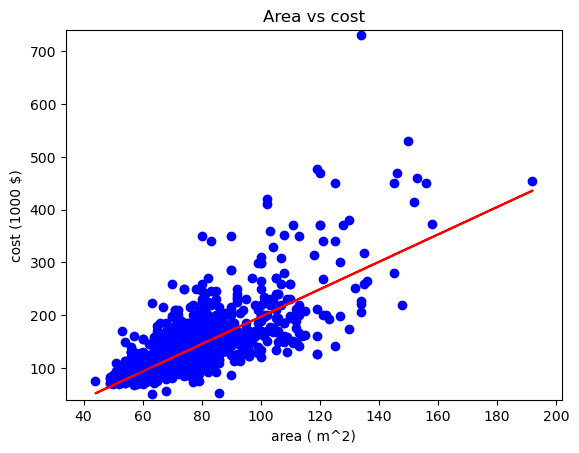

    cnt  Real Y  Predict Y         B1        B2      Sum of E         R
0  2040  260093   260093.0 -62.044844  2.593462 -5.042011e-11  0.756042


In [ ]:
# Experiment № 1
# Description: SLR with full dataset (positive relation)

SLR_solv.Experiment(count=1, full_dataset=True, random_sampling=False, positive=False, cnt_sample=0, viz_with_err=False)

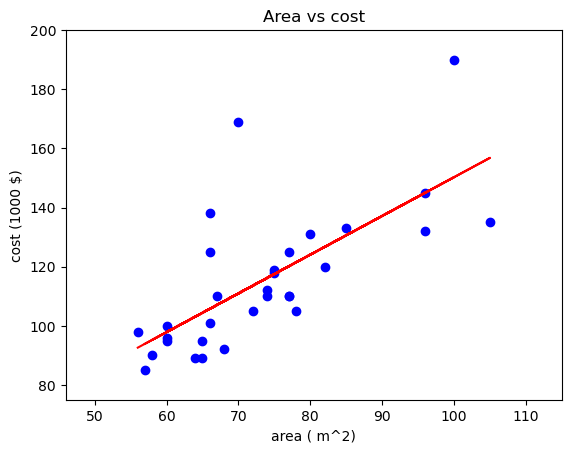

   cnt  Real Y  Predict Y         B1        B2      Sum of E        R
0   31    3572     3572.0  19.234003  1.310324  4.831691e-13  0.69981


In [ ]:
# Experiment № 2
# Description: SLR with datasets sample (positive relation)

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=True, positive=False, cnt_sample=0, viz_with_err=False)

Point 1: y_original=135, y_predict=158.02998642346967, error=-23.029986423469666
Point 2: y_original=126, y_predict=141.62547960569032, error=-15.625479605690316
Point 3: y_original=95, y_predict=72.72655097101705, error=22.273449028982952
Point 4: y_original=104, y_predict=118.65917006079923, error=-14.659170060799227
Point 5: y_original=371, y_predict=302.389646419928, error=68.610353580072
Point 6: y_original=123, y_predict=125.22097278791097, error=-2.2209727879109664
Point 7: y_original=94, y_predict=85.85015642524053, error=8.149843574759473
Point 8: y_original=90, y_predict=62.88384688034944, error=27.116153119650562
Point 9: y_original=108, y_predict=98.973761879464, error=9.026238120535993
Point 10: y_original=129, y_predict=108.81646597013162, error=20.183534029868383
Point 11: y_original=138, y_predict=95.69286051590814, error=42.30713948409186
Point 12: y_original=100, y_predict=138.34457824213445, error=-38.344578242134446
Point 13: y_original=87, y_predict=177.71539460480

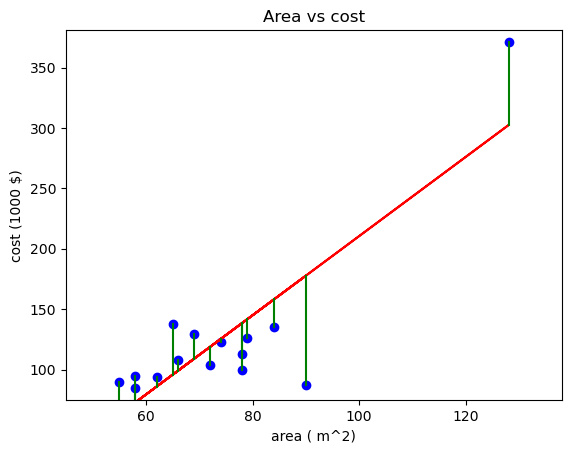

   cnt  Real Y  Predict Y          B1        B2      Sum of E         R
0   15    1898     1898.0 -117.565728  3.280901  2.273737e-13  0.843179


In [ ]:
# Experiment № 3
# Description: SLR with datasets sample (positive relation)

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=False, positive=False, cnt_sample=15,  viz_with_err=True)

In [ ]:
# Experiment № 4
# Description: many SLR with datasets sample (positive relation)

SLR_solv.Experiment(count=50, full_dataset=False, random_sampling=True, positive=False, cnt_sample=0,  viz_with_err=False)

    cnt  Real Y  Predict Y          B1        B2      Sum of E         R
0    43    6013     6013.0 -312.851198  6.152213 -3.410605e-12  0.857079
1    71    9270     9270.0  -42.665821  2.309289  9.094947e-13  0.794403
2    68    8479     8479.0  -86.015943  2.919927 -1.477929e-12  0.830649
3    54    6843     6843.0  -21.503045  1.990096 -2.557954e-13  0.782804
4    64    8633     8633.0  -80.687144  2.946813 -1.989520e-13  0.759313
5    79   10231    10231.0  -27.548729  2.067203  1.762146e-12  0.711340
6    45    4929     4929.0  -23.974052  1.958224 -5.400125e-13  0.735481
7    67    9656     9656.0 -113.286579  3.368399 -8.810730e-13  0.886714
8    31    3614     3614.0  -35.633249  2.151678  2.842171e-14  0.878845
9    97   12076    12076.0  -17.412391  1.946409  7.247536e-13  0.620081
10   34    3992     3992.0  -35.536639  2.144431  6.110668e-13  0.898870
11   69    8428     8428.0  -80.414449  2.826410  4.831691e-13  0.790612
12   58    8005     8005.0  -82.592807  2.968078 -2